<a href="https://colab.research.google.com/github/aliciafmachado/amf-challenge/blob/main/Project_INF569.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Who are the high-frequency traders ?
### by Autorité des Marchés Financiers


Alicia Fortes Machado & Iago Martinelli Lopes

This notebook explore different techniques in order to classify the traders within three categories: HFT, non-HFT and MIX.

The dataset has 35 variables explaining statistics for each set of market player, stock and specific trading date.

## Connect to Google Drive

We connect to Google Drive if you chose this option.

If not, you can jump this section.

In [1]:
# Import and save into google drive
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/MAP569/project'
%ls

Mounted at /content/drive
/content/drive/My Drive/MAP569/project
data/


## Import libraries

We import all necessary libraries:

In [2]:
!pip install prince
!pip install seaborn

In [67]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prince import MFA
from prince import PCA
import seaborn as sns

seaborn.set(style='ticks')

## Dataset

We first open the dataset:

In [4]:
# main path to our dataset
data_path = "data"

train_x_path = os.path.join(data_path, 'AMF_train_X_XCZw8r3.csv')
train_y_path = os.path.join(data_path, 'AMF_train_Y_omYQJZL.csv')

eval_path = os.path.join(data_path, 'AMF_test_X_uDs0jHH.csv')

train_x_df = pd.read_csv(train_x_path, index_col='Index')
train_y_df = pd.read_csv(train_y_path, index_col=None)

eval_df = pd.read_csv(eval_path, index_col='Index')

In [6]:
train_x_df.describe()

,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
count,104099.000000,105782.000000,58170.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,101547.000000,101547.000000,101547.000000,80606.000000,80606.000000,80606.000000,80527.000000,80527.000000,80527.000000,80634.000000,80634.000000,80634.000000,105782.000000
mean,34.435038,17.458787,164.469153,87.472164,2772.513578,103.310102,1011.630575,228.659560,4734.942457,9786.032539,24292.035085,1945.038027,5616.519744,2070.233540,4445.109364,2707.080480,8451.108964,11587.949910,19980.278762,5.563896,25.249324,2.093446,438.447418,1082.427774,651.743386,297.616104,598.637740,389.411017,310.498829,605.733603,401.594794,309.912605,615.154194,402.749527,334.034070
std,137.261154,71.843225,929.010848,1549.972501,4985.149536,1617.051421,4967.426924,2319.866837,10431.964706,14256.357615,17772.438572,6672.112738,9140.189971,6809.714060,9372.947978,7531.875480,13270.509124,15667.418368,17654.559859,4.385260,35.264111,1.417188,2876.755745,3187.357171,2931.984342,1882.353978,2010.296401,1896.835552,1922.648030,2031.797111,1933.073024,1910.028651,2037.041672,1923.023720,644.816702
min,1.044444,2.000000,1.001960,0.000000,0.000065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000065,0.000007,0.000038,0.000016,0.000035,0.000028,0.000038,0.000038,0.000038,1.000000,1.000000,1.000000,0.000001,0.000001,0.000001,0.000001,0.000002,0.000001,0.000001,0.000003,0.000002,0.000001,0.000008,0.000003,1.000000
25%,3.709023,2.753802,3.253655,0.000000,69.365666,0.000000,1.243868,0.000024,22.249021,117.771340,4410.907350,0.000583,67.897392,0.043414,6.234451,0.746623,30.724017,109.431107,1902.260450,2.000000,6.000000,1.500000,0.000007,50.921032,4.915512,0.000005,33.819189,2.533583,0.000006,32.699571,2.305276,0.000020,33.713187,2.639113,24.000000
50%,7.346154,4.789474,14.000000,0.000000,262.325253,0.000109,10.154920,0.093957,114.957445,480.715195,30166.389500,0.044144,272.333702,1.663752,35.734245,8.251923,182.259375,596.792220,17972.680000,5.000000,14.000000,1.880000,0.000091,183.022816,36.457000,0.000232,110.427370,22.413161,0.000260,111.633327,23.665962,0.000270,113.158721,23.435835,97.000000
75%,22.707956,16.366667,73.689116,0.000000,3801.273320,0.020739,60.552090,2.836749,2277.450350,20975.263250,37485.990000,35.497842,9185.177948,69.218030,2075.455025,254.888130,16302.060250,23952.383000,35716.844000,8.000000,30.000000,2.313703,0.001000,714.761762,227.236491,0.008000,367.974973,121.244211,0.051880,376.874393,127.408500,0.059669,380.865913,128.108940,342.000000
max,17561.000000,14409.000000,127861.000000,52568.766000,52568.765625,52568.766000,52568.766000,52568.766000,60597.414000,60609.660000,71934.490000,53171.766000,53171.765625,53171.766000,53171.766000,53171.766000,53646.010000,53909.210000,53909.210000,24.000000,909.000000,63.000000,30929.771000,30929.771000,30929.771000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,12966.000000


Then, we transform the date and the stock identification code to integers:

## Visualization

We plot how many operations were done in each day of the month. We also show the proportion of which were from HFT, NON HFT, MIX:

Now, we create a trader id, in order to join both X and y and also so that we can have visualizations more easily.

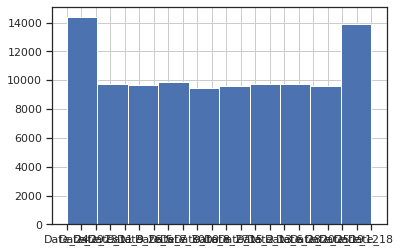

In [9]:
# TODO: how to unify data from y and X
train_x_df['Day'].hist()
plt.show()

We do the same for the shares:

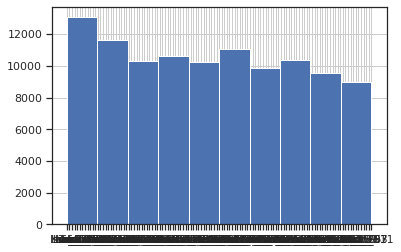

In [10]:
train_x_df['Share'].hist()
plt.show()

## Preprocessing and Unsupervised Learning

### MFA and PCA

We apply unsupervised learning techniques to detect the parameters that are relevant to predict the right category. We use MFA since we have both categorical and continuous variables. This technique joins a PCA and a MCA, methods that are used for continuous and categorical variables, respectively. We will also apply a PCA to our dataset by dummifying the categorical variables. The problem of the last approach is that we have too many different labels for Share, Trader and Day. Thus, it might not be very effective (we only have 35 continuous variables). One option is to change them to continuous values but it is not a good practice.

TODO: DO WE TRY THIS LAST OPTION?

We also accept None as method, and then we only dummify the categorical labels.

In [185]:
def preprocess(raw_data, reduction_method='MFA', n_components=30, dummify=False):
  # We select the categorical columns:
  traders = pd.DataFrame(raw_data[['Trader']], index=raw_data.index.copy(), columns = ["Trader"])
  transform = None

  X = raw_data.drop(columns=['Trader'])
  cat_columns = ['Share', 'Day']

  cat = X[cat_columns]
  num = X.drop(columns=cat_columns)

  # We need to normalize the numerical columns
  num = (num - num.mean()) / num.std()

  # TODO: Fill NA -> Should we do it like this?
  num = num.fillna(num.mean())

  if reduction_method == 'MFA':

    X = pd.concat([num, cat], axis=1)
    groups = {
        'cat': cat_columns
    }

    # TODO: recheck n_iter
    transform = MFA(groups=groups, n_components=n_components, n_iter=1000)
    X = transform.fit_transform(X)

  elif (reduction_method == 'PCA' or
    reduction_method == None):
    
    if not dummify:
      # Transform not continuous variables to 
      #TODO: fix warning
      cat['Day'] = cat.Day.str.extract('(\d+)').astype(int)
      cat['Share'] = cat.Share.str.extract('(\d+)').astype(int)
    else:
      cat = pd.get_dummies(cat).astype(int)

    # We need to normalize all columns
    cat = (cat - cat.mean()) / cat.std()

    # Concatenate X
    X = pd.concat([num, cat], axis=1)

    if reduction_method == 'PCA':
      transform = PCA(n_components=n_components)
      X = transform.fit_transform(X)

  else:
    raise ValueError('Invalid reduction method: {:}. Please use MFA, PCA or None.'
    .format(reduction_method))

  X = pd.merge(traders, X, on="Index")

  return X, transform

In [160]:
X_emb_mfa, transform_mfa = preprocess(train_x_df)

In [181]:
%%capture
X_emb_pca, transform_pca = preprocess(train_x_df, reduction_method='PCA')
X_emb_pca_dum, transform_pca_dum = preprocess(train_x_df, reduction_method='PCA', dummify=True)

In [180]:
%%capture
X_none, _= preprocess(train_x_df, reduction_method=None)
X_none_dum, _= preprocess(train_x_df, reduction_method=None, dummify=True)

In [174]:
# Visualization of the PCA and MFA

def plot_embedding_space(X_emb, Y, plotting_columns=[0, 1], method='MFA', dummify=False):
  X_total = pd.merge(X_emb, Y, on="Trader")

  # Scatterplot
  ax = sns.scatterplot(data=X_total, x=plotting_columns[0], 
                  y=plotting_columns[1], hue="type", 
                  style="type")
  
  title = "First two dimensions of " + method

  if method == 'PCA':
    if dummify == False:
      title += " without dummification"
    else:
      title += " with dummification"

  ax.set_title(title)
  ax.set_xlabel("First dimension")
  ax.set_ylabel("Second dimension")

def plot_explained_inertia(transform, method='MFA', dummify=False):

  title = "Explained inertia for each dimension using " + method

  if method == 'PCA':
    if dummify == False:
      title += " without dummification"
    else:
      title += " with dummification"

  # Scatterplot
  ax = sns.barplot(x=list(range(1, 31)), y=transform.explained_inertia_)
  ax.set_title(title)
  ax.set_xlabel("Dimensions")
  ax.set_ylabel("Explained inertia")


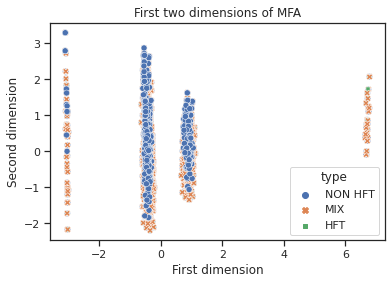

In [165]:
plot_embedding_space(X_emb_mfa, train_y_df, method='MFA')

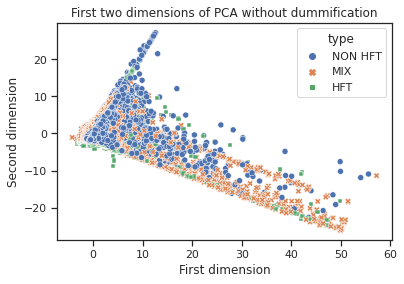

In [171]:
plot_embedding_space(X_emb_pca, train_y_df, method='PCA')

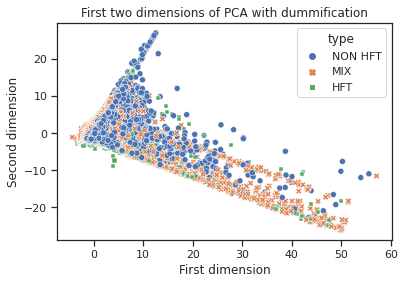

In [183]:
plot_embedding_space(X_emb_pca_dum, train_y_df, method='PCA', dummify=True)

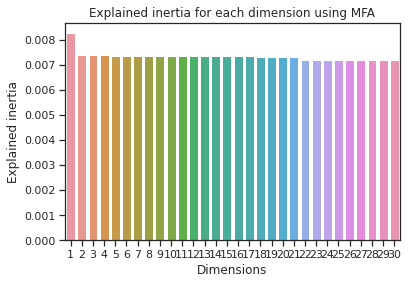

In [176]:
plot_explained_inertia(transform_mfa, method="MFA")

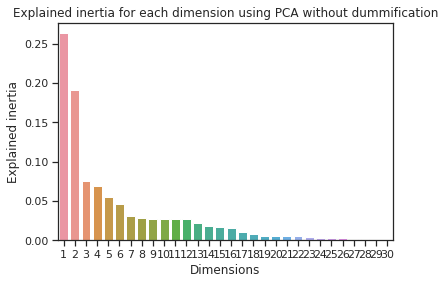

In [175]:
plot_explained_inertia(transform_pca, method="PCA")

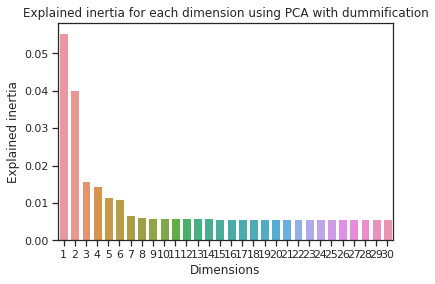

In [188]:
plot_explained_inertia(transform_pca_dum, method="PCA", dummify=True)

From the plots of explained inertia, we can conclude that:



*   PCA without dummification:
*   PCA with dummification:
*   MFA: 

### t-SNE

 Here, we use t-sne to visualize the results of the MFA and PCA.

Notice that we decided to not consider the t-SNE technique as the output varies every time the algorithm is run.

### Clustering

In this subsection, we try to identify clusters to increase our understanding of the data.

### Conclusion

From all these methods, we realize that we should use ...

## Supervised Learning

### Loss function

In the challenge, it is used a micro-averaged F1-score. This one calculates de F1-score shown below by counting globally the total number of true positives, false negatives and false positives.

$$ F1 = 2 \cdot \frac{\text{precision}\cdot\text{recall}}{\text{precision} + \text{recall}} $$

### Methods

Now, after treating our data and identifying the most important parameters, we proceed to apply a supervising learning technique.

Before proceeding to the techniques, we need to first discuss how will we get the classification of each trader from all the points he/she appears.

A first idea is to use the same proportions proposed in the baseline method. However, we can try to go further by finding the right proportion. In order to do that, we first save the predicted value for each line and then we use $n$ different proportions and we see which one fits better the data. This is done for each method and, in the end, we compare all our results. 

### Logistic regression

### Random Forest

### Gradient Boosting

### Neural Network